In [1]:
import glob
import json
import os
import pickle
import sys
import typing
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import sklearn
import yaml
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm

from data.jaad.jaad_data import JAAD
from src.data_utils import JaadDatabase


In [2]:
class BuildSamples(JaadDatabase):
    def __init__(
        self,
        jaad_object: object,
        filename: typing.Union[str, bytes, os.PathLike] = "jaad_database.pkl",
        regen=False,
        processed_dirpath="data/processed",
    ) -> None:
        super().__init__(jaad_object, filename=filename, regen=regen, processed_dirpath=processed_dirpath)

        self.db = self.read_from_pickle("data/processed/jaad_database.pkl")
        self.sequence_dict = None

    def _generate_raw_sequence(self, image_set="all", **opts):
        """
        Generates pedestrian tracks
        :param image_set: the split set to produce for. Options are train, test, val.
        :param opts:
                'fstride': Frequency of sampling from the data.
                'sample_type': Whether to use 'all' pedestrian annotations or the ones
                                    with 'beh'avior only.
                'subset': The subset of data annotations to use. Options are: 'default': Includes high resolution and
                                                                                        high visibility videos
                                                                        'high_visibility': Only videos with high
                                                                                            visibility (include low
                                                                                            resolution videos)
                                                                        'all': Uses all videos
                'height_rng': The height range of pedestrians to use.
                'squarify_ratio': The width/height ratio of bounding boxes. A value between (0,1]. 0 the original
                                        ratio is used.
                'data_split_type': How to split the data. Options: 'default', predefined sets, 'random', randomly split the data,
                                        and 'kfold', k-fold data split (NOTE: only train/test splits).
                'seq_type': Sequence type to generate. Options: 'trajectory', generates tracks, 'crossing', generates
                                tracks up to 'crossing_point', 'intention' generates tracks similar to human experiments
                'min_track_size': Min track length allowable.
                'random_params: Parameters for random data split generation. (see _get_random_pedestrian_ids)
                'kfold_params: Parameters for kfold split generation. (see _get_kfold_pedestrian_ids)
        :return: Sequence data in the form
        ---------------------------
        keys = dict_keys(['image', 'pid', 'bbox', 'center', 'occlusion', 'intent'])

        {'image': [['../data/jaad/images/video_0001/00000.png',
                    '../data/jaad/images/video_0001/00001.png',
                    '../data/jaad/images/video_0001/00002.png',
                    '../data/jaad/images/video_0001/00003.png',
                    '../data/jaad/images/video_0001/00004.png',...
        'pid': [[['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],
                ['0_1_2b'],...
        ---------------------------
        """
        params = {
            "fstride": 1,
            "sample_type": "all",  # 'beh'
            "subset": "default",
            "height_rng": [0, float("inf")],
            "squarify_ratio": 0,
            "data_split_type": "default",  # kfold, random, default
            "seq_type": "intention",
            "min_track_size": 15,
            "random_params": {"ratios": None, "val_data": True, "regen_data": False},
            "kfold_params": {"num_folds": 5, "fold": 1},
        }
        assert all(k in params for k in opts.keys()), "Wrong option(s)." "Choose one of the following: {}".format(
            list(params.keys())
        )
        params.update(opts)
        return self.jaad_object.generate_data_trajectory_sequence(image_set, **params)


    def _raw_sequence_transformer(self, sequence_data: dict, window, **opts):
        """
        Parses a single sequence from _generate_raw_sequence (by calling generate_sequence_samples)
        :param sequence_data: The sequence data to parse. Comes in the form dict(image, pid, intent)
        :param window: The window size to use
        """

        # unpack dict(image, pid)
        image_list, pid_list, intent = sequence_data["image"], sequence_data["pid"], sequence_data["intent"]

        # PID is the same along the array, then we just need one
        pid = pid_list[0][0]

        # same for video_name
        video_name = image_list[0].split("/")[-2]

        # get rolling windows
        sliding_windows_image_array = sliding_window_view(image_list, window)
        sliding_windows_intent_array = sliding_window_view(intent, window, 0)

        sliding_window_frame_id = [
            pd.Series(arr).str.extract("(\d{5})").astype(int).to_numpy().flatten() for arr in sliding_windows_image_array
        ]  # array([['../data/jaad/images/video_0001/00000.png', '../data/jaad/images/video_0001/00001.png' => [array([0, 1, 2, 3, 4...]), array([1, 2, 3, 4, 5...])....

        # frames of the pid
        pid_frames = self.db[video_name]['ped_annotations'][pid]['frames']
        skeletons = self.db[video_name]['ped_annotations'][pid]['skeleton_keypoints']
        
        # apply savgol filter
        skeletons = self._apply_savgol_filter(skeletons, window_size=11, polyorder=3)

        array_with_sequences = []
        for array_ix, array in enumerate(sliding_window_frame_id):  # an array contain the ids of the frames for that sliding window
            skeletons_single_sequence = []
            confidence_single_sequence = []
            for ix in array:
                try:
                    frame_skeleton = skeletons[pid_frames.index(ix), :, :]
                except IndexError:
                    frame_skeleton = None
                if (frame_skeleton is None) or (np.isnan(frame_skeleton).all()):
                    break
                skeletons_single_sequence.append(frame_skeleton[:, :2])
                confidence_single_sequence.append(frame_skeleton[:, 2])
            assert all(len(lst['frame_sequence']) == len(array) for lst in array_with_sequences), "Skeleton length does not match array length"
            if frame_skeleton is not None:
                data = {
                    'video_name': video_name,
                    'pid': pid,
                    'frame_sequence': array,
                    'skeleton_sequence': skeletons_single_sequence,
                    'confidence': confidence_single_sequence,
                    'intent': sliding_windows_intent_array[array_ix].flatten()

                }
                array_with_sequences.append(data)


        return array_with_sequences
    
    
    def _apply_savgol_filter(self, skeletons, window_size=11, polyorder=3):
        """
        Applies Savgol filter to the array
        :param skeletons: The array of frames containing skeletons
        :param window_size: The window size
        :param polyorder: The polynomial order
        :return: The filtered array
        """
        for i, _arr in enumerate(skeletons):
            if _arr is None:
                _arr = np.empty((25, 3))
                _arr[:] = np.NaN
            skeletons[i] = _arr

        stack = np.vstack(skeletons).reshape(-1, 75)
        for i in range(stack.shape[1]):
            stack[:, i] = signal.savgol_filter(stack[:, i], window_size, polyorder)

        stack = stack.reshape(-1, 25, 3)
        return stack

    def _parse_raw_sequence(self, sequence_data, **opts):
        """

        Args:
            sequence_data (dict): sequence_data from _generate_raw_sequence

        Returns:
            dict: In the shape of:
            [
               [
                   {
                       'video_name': 'video_0001',
                        'pid': '0_1_2b',
                        'frame_sequence': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), -> single array
                        'skeleton_sequence': [array([[1447.6762,  675.5998],...array([[...]])] -> multiple arrays, one per frame of frame_sequence.
                        'confidence': [array([0.796439, 0.76417...],...array([[0.....]])], -> multiple arrays, one per frame of frame_sequence,
                        'intent': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) -> single array, one element per frame
                    },
                    
                    {
                        'video_name': 'video_0001',
                        'pid': '0_1_2b',
                        'frame_sequence': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), -> NOTE this is what change between elements of the list !NOTE
                        'skeleton_sequence': [array([[1450.5655,  675.1043],...
                    },
                    ...
                ] NOTE this whole list was just for video_0001 and pedestrian_id 0_1_2b...,
                [
                    NEW LIST FOR video_0001 and pedestrian_id 0_1_3b
                ],
                [
                    NEW LIST FOR video_0002 and pedestrian_id ...
                ],
        """
        
        params = {}
        params.update(opts)
        
        # if visualize_inner_func is True, we want to print the sequence data to look at it
        print("+" * 30, "Print raw sequence data", sequence_data, "+" * 30, sep="\n") if params["visualize_inner_func"] else None
        
        sequence_dict = {
            'sequences_count': 0,
            'pos_sequences': 0,
            'sequences': [],
        }
        
        print('-'*70, 'Parsing sequence data', sep='\n')
        for ith_sample in tqdm(range(len(sequence_data['image']))):
            sample_data = {"image": sequence_data['image'][ith_sample], 'pid': sequence_data['pid'][ith_sample], 'intent': sequence_data['intent'][ith_sample]}
            parsed_sample = self._raw_sequence_transformer(sequence_data=sample_data, window=params['min_track_size'])
            sequence_dict['sequences'].append(parsed_sample)
            sequence_dict['sequences_count'] += len(parsed_sample)
            for i in parsed_sample:
                if i['intent'][0] == 1:
                    sequence_dict['pos_sequences'] += 1
            
        return sequence_dict
    
    def _transform_features(self, sequence_dict):
        # TODO this
        raise NotImplementedError("Transforming features not implemented yet")
        
    def generate_sequence_samples(self, image_set="all", window=15, visualize_inner_func=False, save=True, regen=False, **opts):

        """
        Calls _generate_raw_sequence to generate sequence data.
        :param image_set: the split set to produce for. Options are train, test, val.

        :return: Sequence data
        """
        params = {
            "sample_type": "beh",
            "height_rng": [60, float("inf")],
            "min_track_size": window,
        }
        assert all(k in params for k in opts.keys()), "Wrong option(s)." "Choose one of the following: {}".format(
            list(params.keys())
        )
        
        # SECTION: LOAD FILE OR RUN FUNCTIONS FOR PARSED SEQUENCES DICT
        # load sample_sequence_dict if exist and regen is false
        sample_sequence_dict_path = Path(self.processed_dirpath) / 'sample_sequence_dict.pkl'
        print(f"Function running with parameter regen: {regen}")
        if not regen:
            if sample_sequence_dict_path.exists():
                print(f'Loading saved file from {str(sample_sequence_dict_path)}')
                with open(str(sample_sequence_dict_path), 'rb') as file:
                    parsed_sequences = pickle.load(file)
                return parsed_sequences
            else:
                print(f'No previous pickle file found on {str(sample_sequence_dict_path)}', 'Generating...', sep='\n')
        
        if regen: # Print notice nto user
            print(f'Forcing regeneration of {sample_sequence_dict_path}')
        
        # run functions
        sequence_data = self._generate_raw_sequence(image_set, **params)
        parsed_sequences = self._parse_raw_sequence(sequence_data=sequence_data, **params, visualize_inner_func=visualize_inner_func)
        if save:
            with open('data/processed/sample_sequence_dict.pkl', 'wb') as file:
                pickle.dump(parsed_sequences, file)
        # !SECTION
        
        
                    
        # FIXME: This is not the final return value     
        return parsed_sequences # return attribute


In [3]:
builder = BuildSamples(jaad_object=JAAD('data/jaad'))

data = builder.generate_sequence_samples(regen=True)

Function running with parameter regen: True
Forcing regeneration of data/processed/sample_sequence_dict.pkl
---------------------------------------------------------
Generating action sequence data
fstride: 1
sample_type: beh
subset: default
height_rng: [60, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad
jaad database loaded from /Users/seba/local-projects/pedestrians/data/jaad/data_cache/jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: all
Number of pedestrians: 648 
Total number of samples: 600 
----------------------------------------------------------------------
Parsing sequence data


100%|██████████| 600/600 [00:17<00:00, 35.11it/s]


In [5]:
builder._transform_features(data)

NotImplementedError: Transforming features not implemented yet

In [7]:
single_seq = data['sequences'][0][1]['skeleton_sequence']
single_seq = np.array(single_seq)

In [6]:
data['sequences'][0][1].keys()

dict_keys(['video_name', 'pid', 'frame_sequence', 'skeleton_sequence', 'confidence', 'intent'])

In [7]:
print(type(single_seq), single_seq.shape)

<class 'numpy.ndarray'> (15, 25, 2)


In [8]:
A = single_seq[0]
A

array([[1450.5655,  675.1043],
       [1452.3526,  671.5244],
       [1445.6452,  672.8617],
       [   0.    ,    0.    ],
       [1435.3703,  675.1   ],
       [1461.288 ,  695.65  ],
       [1421.9652,  699.226 ],
       [1477.377 ,  715.754 ],
       [1412.1356,  734.523 ],
       [1456.3703,  687.162 ],
       [1410.3475,  767.584 ],
       [1456.8231,  770.711 ],
       [1433.5869,  771.608 ],
       [1452.7952,  823.881 ],
       [1443.8641,  825.225 ],
       [1452.7972,  865.437 ],
       [1451.9047,  873.476 ],
       [1443.4151,  691.63  ],
       [1445.2083,  657.2264],
       [1460.3948,  873.476 ],
       [1461.7353,  871.246 ],
       [1445.2032,  870.348 ],
       [1459.9481,  876.606 ],
       [1454.5862,  881.074 ],
       [1451.9032,  880.629 ]])

In [11]:
A.sum(axis=0)/A.shape[0]

array([1389.503304,  741.082512])

In [13]:
class BodyMapper:
    def __init__(self, arr: np.ndarray) -> None:
        self.arr = arr
    
        self.parts = {}
        self.body_map_path = 'data/helper_data/body_25b_parts.yaml'
        self.body_parts_dict = self._load_body_parts()
        
        self._map_to_dict(self.arr, self.body_parts_dict)
    
    def _load_body_parts(self):
        return yaml.load(Path.read_text(Path(self.body_map_path)), Loader=yaml.SafeLoader)
        
    def _map_to_dict(self, arr, body_dict):
        for k, v in body_dict.items():
            self.parts[v] = arr[k, :]
        

In [14]:
d = data['sequences'][0][1]
A = d['skeleton_sequence'][0]

body = BodyMapper(A)

In [15]:
import matplotlib.pyplot as plt

In [16]:
p = Path('/Users/seba/local-projects/pedestrians/data/processed/keypoints/video_0021/json/0_21_92b/00141_keypoints.json')
with open(p, 'rb') as f:
    j = json.load(f)
keypoints = j['people'][0]['pose_keypoints_2d']
arr = np.array(keypoints).reshape(-1, 3)[:, :2]

In [58]:
Nose= arr[0]
LEye= arr[1]
REye= arr[2]
LEar= arr[3]
REar= arr[4]
LShoulder= arr[5]
RShoulder= arr[6]
LElbow= arr[7]
RElbow= arr[8]
LWrist= arr[9]
RWrist= arr[10]
LHip= arr[11]
RHip= arr[12]
LKnee= arr[13]
RKnee= arr[14]
LAnkle= arr[15]
RAnkle= arr[16]
Neck= arr[17]
HeadTop= arr[18]
LBigToe= arr[19]
LSmallToe= arr[20]
LHeel= arr[21]
RBigToe= arr[22]
RSmallToe= arr[23]
RHeel= arr[24]

(0.0, 148.0)

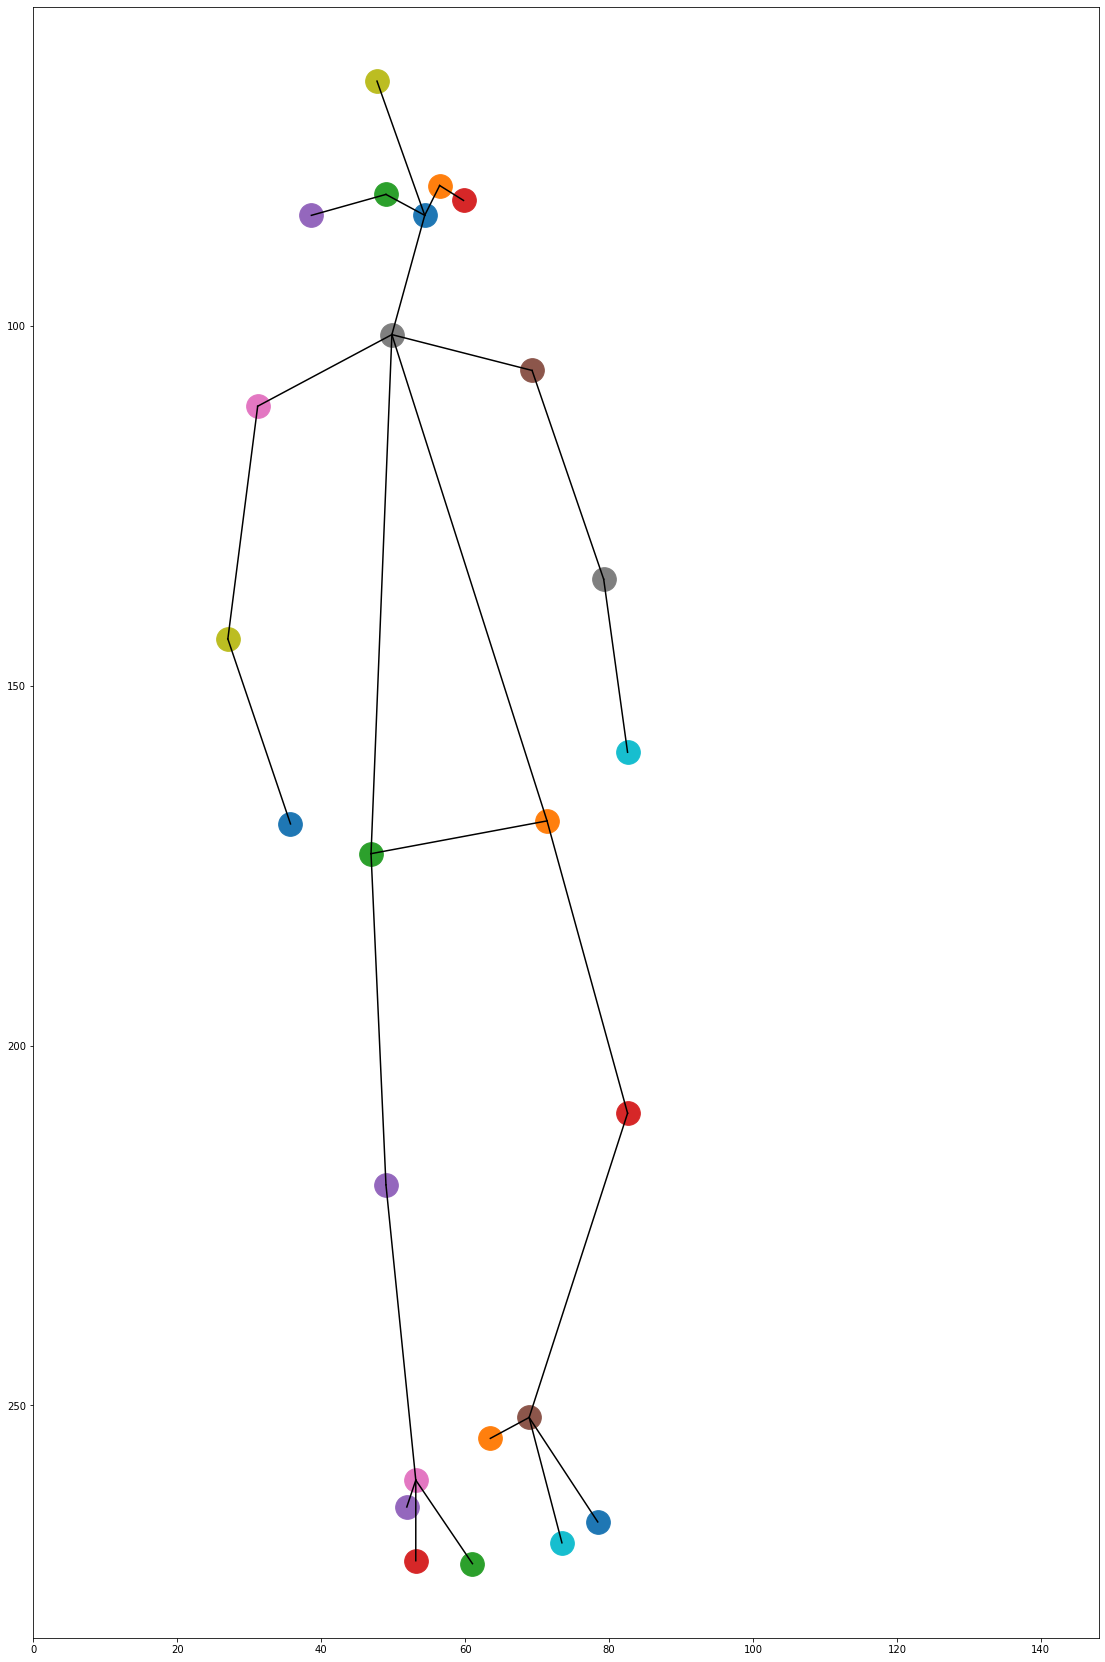

In [27]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
    
plt.figure(figsize=(40,30))
x_ = 148
y_ = 401 
for v in arr:
    if (v.any()> 0):
        plt.scatter(x=v[0], y=v[1], s=560)


plot_line(LEar, LEye)
plot_line(REar, REye)
plot_line(LEye, Nose)
plot_line(REye, Nose)
plot_line(Nose, Neck)
plot_line(Neck, LShoulder)
plot_line(LShoulder, LElbow)
plot_line(LElbow, LWrist)
plot_line(Neck, RShoulder)
plot_line(RShoulder, RElbow)
plot_line(RElbow, RWrist)
plot_line(Neck, LHip)
plot_line(LHip, LKnee)
plot_line(LHip, RHip)
plot_line(LKnee, LAnkle)
plot_line(Neck, RHip)
plot_line(RHip, RKnee)
plot_line(RKnee, RAnkle)
plot_line(HeadTop, Nose)
plot_line(LAnkle, LBigToe)
plot_line(LAnkle, LHeel)
plot_line(LAnkle, LSmallToe)
plot_line(RAnkle, RBigToe)
plot_line(RAnkle, RHeel)
plot_line(RAnkle, RSmallToe)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.xlim([0,x_])


In [61]:
length_Neck_HeadTop

35.28069593928102

In [71]:
# Length of head
length_Neck_HeadTop = scipy.spatial.distance.euclidean(Neck, HeadTop)
length_Neck_LEar = scipy.spatial.distance.euclidean(Neck, LEar)
length_Neck_REar = scipy.spatial.distance.euclidean(Neck, REar)
length_Neck_LEye = scipy.spatial.distance.euclidean(Neck, LEye)
length_Neck_REye = scipy.spatial.distance.euclidean(Neck, REye)
length_Nose_LEar = scipy.spatial.distance.euclidean(Nose, LEar)
length_Nose_REar = scipy.spatial.distance.euclidean(Nose, REar)
length_Nose_LEye = scipy.spatial.distance.euclidean(Nose, LEye)
length_Nose_REye = scipy.spatial.distance.euclidean(Nose, REye)
length_head      = np.maximum.reduce([length_Neck_HeadTop, length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
# Length of torso
length_Neck_LHip = scipy.spatial.distance.euclidean(Neck, LHip)
length_Neck_RHip = scipy.spatial.distance.euclidean(Neck, RHip)
length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)

# Length of right leg
length_leg_right = scipy.spatial.distance.euclidean(RHip, RKnee) + scipy.spatial.distance.euclidean(RKnee, RAnkle)

# Length of left leg
length_leg_left = scipy.spatial.distance.euclidean(LHip, LKnee) + scipy.spatial.distance.euclidean(LKnee, LAnkle)

# Length of leg
length_leg = np.maximum(length_leg_right, length_leg_left)

# Length of body
length_body = length_head + length_torso + length_leg

# Check all samples have length_body of 0
length_chk = (length_body > 0).astype(int)

In [72]:
length_body

194.7603506720634

(-0.2, 0.8)

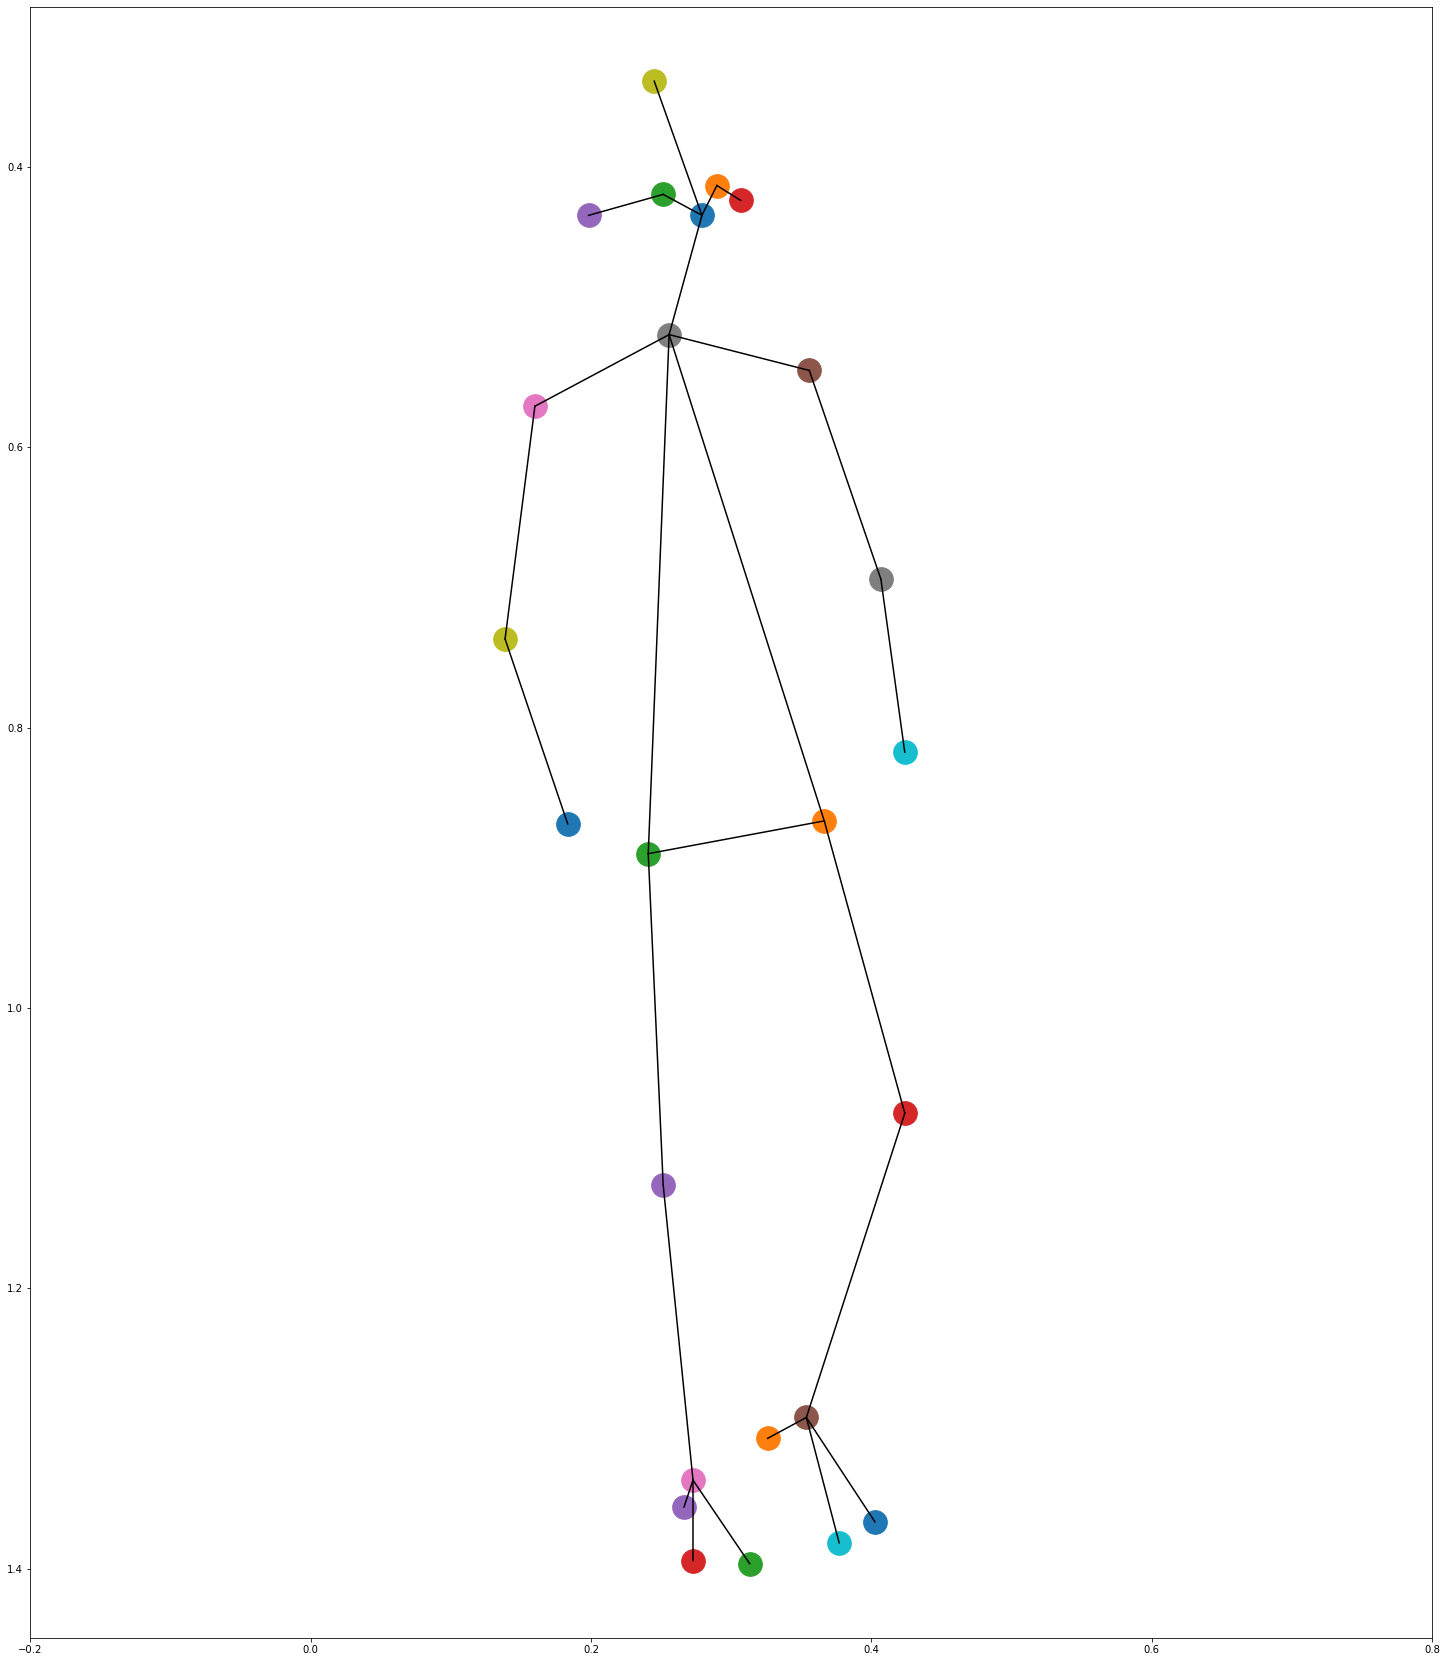

In [82]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
x_ = 148
y_ = 401 
plt.figure(figsize=(40,30))
for v in arr:
    if (v.any()> 0):
        plt.scatter(x=v[0]/length_body, y=v[1]/length_body, s=560)


plot_line(LEar/length_body, LEye/length_body)
plot_line(REar/length_body, REye/length_body)
plot_line(LEye/length_body, Nose/length_body)
plot_line(REye/length_body, Nose/length_body)
plot_line(Nose/length_body, Neck/length_body)
plot_line(Neck/length_body, LShoulder/length_body)
plot_line(LShoulder/length_body, LElbow/length_body)
plot_line(LElbow/length_body, LWrist/length_body)
plot_line(Neck/length_body, RShoulder/length_body)
plot_line(RShoulder/length_body, RElbow/length_body)
plot_line(RElbow/length_body, RWrist/length_body)
plot_line(Neck/length_body, LHip/length_body)
plot_line(LHip/length_body, LKnee/length_body)
plot_line(LHip/length_body, RHip/length_body)
plot_line(LKnee/length_body, LAnkle/length_body)
plot_line(Neck/length_body, RHip/length_body)
plot_line(RHip/length_body, RKnee/length_body)
plot_line(RKnee/length_body, RAnkle/length_body)
plot_line(HeadTop/length_body, Nose/length_body)
plot_line(LAnkle/length_body, LBigToe/length_body)
plot_line(LAnkle/length_body, LHeel/length_body)
plot_line(LAnkle/length_body, LSmallToe/length_body)
plot_line(RAnkle/length_body, RBigToe/length_body)
plot_line(RAnkle/length_body, RHeel/length_body)
plot_line(RAnkle/length_body, RSmallToe/length_body)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.xlim([-.2, 0.8])


In [101]:
np.triu(scipy.spatial.distance.cdist(arr, arr, 'cosine'), 0)

array([[0.00000000e+00, 8.21220325e-04, 4.83169769e-04, 1.53737266e-03,
        1.01965406e-02, 2.50261310e-05, 4.39952842e-02, 8.38254094e-04,
        7.31820290e-02, 4.30312722e-03, 6.51626458e-02, 1.45895879e-02,
        4.66799679e-02, 1.90537074e-02, 6.10929523e-02, 4.58356124e-02,
        6.75991747e-02, 6.45768132e-03, 1.52665413e-03, 4.60532625e-02,
        4.02276318e-02, 5.28824010e-02, 6.07806837e-02, 7.05545371e-02,
        7.02680922e-02],
       [0.00000000e+00, 0.00000000e+00, 2.56340601e-03, 1.11415785e-04,
        1.67808671e-02, 5.59567420e-04, 5.66665922e-02, 3.31748459e-03,
        8.91583705e-02, 8.87568492e-03, 8.03175853e-02, 2.22949074e-02,
        5.96979569e-02, 2.77312201e-02, 7.58093613e-02, 5.87457546e-02,
        8.30093953e-02, 1.18709392e-02, 1.08542985e-04, 5.89913063e-02,
        5.23926317e-02, 6.66621086e-02, 7.54627836e-02, 8.62675824e-02,
        8.59521020e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.74265967e-03,
        6.2474

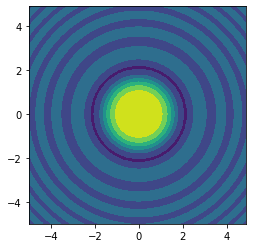

In [123]:
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y, sparse=False)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x, y, z)
plt.axis('scaled')
plt.show()

In [125]:
xx**2

array([[25.  , 24.01, 23.04, ..., 22.09, 23.04, 24.01],
       [25.  , 24.01, 23.04, ..., 22.09, 23.04, 24.01],
       [25.  , 24.01, 23.04, ..., 22.09, 23.04, 24.01],
       ...,
       [25.  , 24.01, 23.04, ..., 22.09, 23.04, 24.01],
       [25.  , 24.01, 23.04, ..., 22.09, 23.04, 24.01],
       [25.  , 24.01, 23.04, ..., 22.09, 23.04, 24.01]])

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class Transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return scipy.spatial.distance.cdist(X, X, 'cosine')

In [13]:
a = Transform()

In [17]:
a.fit_transform(A)

array([[0.00000000e+00, 3.12415962e-06, 3.62319064e-10,            nan,
        8.15934194e-06, 3.79669360e-05, 2.29370912e-04, 1.21035936e-04,
        9.69820769e-04, 1.38731953e-05, 1.97292904e-03, 1.30085091e-03,
        1.69161009e-03, 3.22107648e-03, 3.49551332e-03, 5.16311460e-03,
        5.61353059e-03, 6.32361898e-05, 3.85925166e-05, 5.34467919e-03,
        5.18797058e-03, 5.66220087e-03, 5.52290945e-03, 5.93712222e-03,
        6.00197702e-03],
       [3.12415962e-06, 0.00000000e+00, 3.19181060e-06,            nan,
        2.13811873e-05, 6.28728347e-05, 2.86029690e-04, 1.63049927e-04,
        1.08300372e-03, 3.01641956e-05, 2.13298849e-03, 1.43142949e-03,
        1.84006143e-03, 3.42465937e-03, 3.70744647e-03, 5.41990532e-03,
        5.88112399e-03, 9.44708897e-05, 1.97559849e-05, 5.60587953e-03,
        5.44536955e-03, 5.93093498e-03, 5.78836556e-03, 6.21220890e-03,
        6.27854053e-03],
       [3.62319064e-10, 3.19181060e-06, 0.00000000e+00,            nan,
        8.0509

In [18]:
A

array([[1450.5655,  675.1043],
       [1452.3526,  671.5244],
       [1445.6452,  672.8617],
       [   0.    ,    0.    ],
       [1435.3703,  675.1   ],
       [1461.288 ,  695.65  ],
       [1421.9652,  699.226 ],
       [1477.377 ,  715.754 ],
       [1412.1356,  734.523 ],
       [1456.3703,  687.162 ],
       [1410.3475,  767.584 ],
       [1456.8231,  770.711 ],
       [1433.5869,  771.608 ],
       [1452.7952,  823.881 ],
       [1443.8641,  825.225 ],
       [1452.7972,  865.437 ],
       [1451.9047,  873.476 ],
       [1443.4151,  691.63  ],
       [1445.2083,  657.2264],
       [1460.3948,  873.476 ],
       [1461.7353,  871.246 ],
       [1445.2032,  870.348 ],
       [1459.9481,  876.606 ],
       [1454.5862,  881.074 ],
       [1451.9032,  880.629 ]])